# **Getting weather data**

To get some weather data, I used the script from the following article: 
https://towardsdatascience.com/obtain-historical-weather-forecast-data-in-csv-format-using-python-5a6c090fc828


# **Loading the data**

In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import keras
from keras.preprocessing.sequence import TimeseriesGenerator
import io
from google.colab import files
import matplotlib.pyplot as plt
import random

import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 

random.seed(2) # so that i get the same results every time 



# in case of google colab use 
#uploaded = files.upload()
#df = pd.read_csv(io.BytesIO(uploaded['budapest.csv'])).dropna()

#if no colab
df = pd.read_csv('budapest.csv')


df.index = df['date_time']           #so that the indexes are the dates now
del df['date_time']                  #we dont need that date anymore 
df.index = pd.to_datetime(df.index)  #need to convert it to datetime

df.tail()





Saving budapest.csv to budapest (5).csv


,maxtempC,mintempC,totalSnow_cm,sunHour,uvIndex,moon_illumination,moonrise,moonset,sunrise,sunset,DewPointC,FeelsLikeC,HeatIndexC,WindChillC,WindGustKmph,cloudcover,humidity,precipMM,pressure,tempC,visibility,winddirDegree,windspeedKmph,location
date_time,,,,,,,,,,,,,,,,,,,,,,,,
2020-10-23,16,11,0.0,3.9,3,42,01:40 PM,10:17 PM,06:14 AM,04:41 PM,10,13,14,13,7,73,81,0.0,1017,16,10,247,5,budapest
2020-10-24,16,12,0.0,7.1,3,49,02:16 PM,11:25 PM,06:16 AM,04:39 PM,11,14,14,14,8,67,81,0.0,1016,16,10,323,6,budapest
2020-10-25,13,9,0.0,3.8,3,56,02:46 PM,No moonset,06:17 AM,04:37 PM,11,12,13,12,8,100,90,8.0,1014,13,8,73,6,budapest
2020-10-26,18,11,0.0,7.1,3,64,03:10 PM,12:32 AM,06:19 AM,04:35 PM,10,14,14,14,20,54,78,0.0,1011,18,8,174,14,budapest
2020-10-27,18,12,0.0,8.7,5,71,03:30 PM,01:39 AM,06:20 AM,04:34 PM,10,14,15,14,12,12,74,0.0,1012,18,10,109,8,budapest


# **EDA**

It's time to get some feel for the data. 



In [2]:
df.info()
df.describe()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3953 entries, 2010-01-01 to 2020-10-27
Data columns (total 24 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   maxtempC           3953 non-null   int64  
 1   mintempC           3953 non-null   int64  
 2   totalSnow_cm       3953 non-null   float64
 3   sunHour            3953 non-null   float64
 4   uvIndex            3953 non-null   int64  
 5   moon_illumination  3953 non-null   int64  
 6   moonrise           3953 non-null   object 
 7   moonset            3953 non-null   object 
 8   sunrise            3953 non-null   object 
 9   sunset             3953 non-null   object 
 10  DewPointC          3953 non-null   int64  
 11  FeelsLikeC         3953 non-null   int64  
 12  HeatIndexC         3953 non-null   int64  
 13  WindChillC         3953 non-null   int64  
 14  WindGustKmph       3953 non-null   int64  
 15  cloudcover         3953 non-null   int64  
 16  humidi

,maxtempC,mintempC,totalSnow_cm,sunHour,uvIndex,moon_illumination,DewPointC,FeelsLikeC,HeatIndexC,WindChillC,WindGustKmph,cloudcover,humidity,precipMM,pressure,tempC,visibility,winddirDegree,windspeedKmph
count,3953.000000,3953.000000,3953.000000,3953.000000,3953.000000,3953.000000,3953.000000,3953.000000,3953.000000,3953.000000,3953.000000,3953.000000,3953.000000,3953.000000,3953.000000,3953.000000,3953.000000,3953.000000,3953.000000
mean,15.168227,7.957754,0.055477,10.271895,3.650392,46.068050,5.949406,11.086517,12.501391,10.996205,16.636479,38.136605,68.731090,0.960359,1016.656463,15.168227,9.413863,191.985581,10.875285
std,10.592459,7.896983,0.445605,3.624449,1.794958,31.256484,6.960121,10.461303,9.300242,10.333421,7.341452,27.117464,14.845332,2.605467,7.529858,10.592459,1.602197,91.436883,4.800618
min,-10.000000,-17.000000,0.000000,3.100000,1.000000,0.000000,-21.000000,-20.000000,-13.000000,-20.000000,3.000000,0.000000,26.000000,0.000000,982.000000,-10.000000,0.000000,0.000000,2.000000
25%,6.000000,2.000000,0.000000,8.300000,2.000000,18.000000,1.000000,3.000000,5.000000,3.000000,11.000000,15.000000,58.000000,0.000000,1012.000000,6.000000,9.000000,125.000000,7.000000
50%,16.000000,8.000000,0.000000,11.100000,4.000000,46.000000,7.000000,12.000000,13.000000,12.000000,15.000000,32.000000,69.000000,0.000000,1016.000000,16.000000,10.000000,199.000000,10.000000
75%,24.000000,14.000000,0.000000,13.700000,5.000000,73.000000,12.000000,20.000000,20.000000,20.000000,21.000000,58.000000,80.000000,0.700000,1021.000000,24.000000,10.000000,272.000000,14.000000
max,39.000000,27.000000,18.600000,14.500000,8.000000,100.000000,20.000000,33.000000,33.000000,34.000000,50.000000,100.000000,100.000000,39.800000,1043.000000,39.000000,20.000000,348.000000,32.000000


In [3]:
df.shape

(3953, 24)

In [4]:
df.isna().sum()  #we love to see that there is no "na", even though later we realize that missing values can be seen as zeros in this dataset

maxtempC             0
mintempC             0
totalSnow_cm         0
sunHour              0
uvIndex              0
moon_illumination    0
moonrise             0
moonset              0
sunrise              0
sunset               0
DewPointC            0
FeelsLikeC           0
HeatIndexC           0
WindChillC           0
WindGustKmph         0
cloudcover           0
humidity             0
precipMM             0
pressure             0
tempC                0
visibility           0
winddirDegree        0
windspeedKmph        0
location             0
dtype: int64

In [5]:
df.columns

Index(['maxtempC', 'mintempC', 'totalSnow_cm', 'sunHour', 'uvIndex',
       'moon_illumination', 'moonrise', 'moonset', 'sunrise', 'sunset',
       'DewPointC', 'FeelsLikeC', 'HeatIndexC', 'WindChillC', 'WindGustKmph',
       'cloudcover', 'humidity', 'precipMM', 'pressure', 'tempC', 'visibility',
       'winddirDegree', 'windspeedKmph', 'location'],
      dtype='object')

In [6]:
df['avgtemp'] = df.apply(lambda row: (row.maxtempC + row.mintempC) / 2, axis = 1 )  #lets create our avgtemp column, which will be the target
df.head()

,maxtempC,mintempC,totalSnow_cm,sunHour,uvIndex,moon_illumination,moonrise,moonset,sunrise,sunset,DewPointC,FeelsLikeC,HeatIndexC,WindChillC,WindGustKmph,cloudcover,humidity,precipMM,pressure,tempC,visibility,winddirDegree,windspeedKmph,location,avgtemp
date_time,,,,,,,,,,,,,,,,,,,,,,,,,
2010-01-01,6,3,0.0,6.9,1,100,05:00 PM,08:04 AM,07:32 AM,04:03 PM,4,3,5,3,16,64,94,0.8,992,6,5,175,9,budapest,4.5
2010-01-02,3,-1,0.0,3.3,1,85,06:25 PM,08:41 AM,07:32 AM,04:04 PM,0,-3,1,-3,31,75,89,1.7,1003,3,5,286,21,budapest,1.0
2010-01-03,-1,-4,0.0,3.3,1,77,07:51 PM,09:10 AM,07:32 AM,04:05 PM,-5,-9,-2,-9,39,82,79,1.7,1016,-1,8,319,26,budapest,-2.5
2010-01-04,-3,-7,0.0,8.7,2,70,09:12 PM,09:34 AM,07:32 AM,04:06 PM,-7,-8,-4,-8,16,38,80,0.0,1021,-3,10,195,10,budapest,-5.0
2010-01-05,-3,-5,1.0,3.3,1,63,10:31 PM,09:56 AM,07:31 AM,04:07 PM,-5,-9,-4,-9,25,91,92,1.1,1013,-3,7,90,17,budapest,-4.0


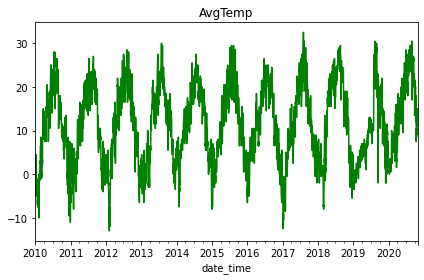

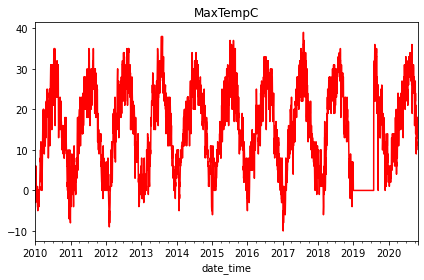

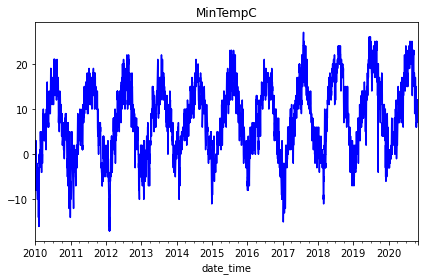

In [7]:
import matplotlib.pyplot as plt

#plot avgtemp, maxtemp and mintemp from 2010 to 2020, maybe we can see a pattern or something interesting

df.avgtemp.plot(title='AvgTemp', color='green') 
plt.tight_layout()
plt.show()   

df.maxtempC.plot(title='MaxTempC', color='red') 
plt.tight_layout()
plt.show() 

df.mintempC.plot(title='MinTempC', color='blue') 
plt.tight_layout()
plt.show() 

In [8]:
#I drop the dates between 2019-01-01 and 2019-08-31 because some key values are missing
#I also drop 2019-09-16, because as we can see on the plot, that's a heavy outlier. 

start_remove = pd.to_datetime('2019-01-01')
end_remove = pd.to_datetime('2019-08-31')

special = pd.to_datetime('2019-09-16')
df = df.query('index < @start_remove or index > @end_remove')

df = df.query('index < @special or index > @special')

pd.concat([df[:start_remove], df[end_remove:]])
print(df.shape)

(3709, 25)


In [9]:
# Lets see how it looks now 
df.tail()

,maxtempC,mintempC,totalSnow_cm,sunHour,uvIndex,moon_illumination,moonrise,moonset,sunrise,sunset,DewPointC,FeelsLikeC,HeatIndexC,WindChillC,WindGustKmph,cloudcover,humidity,precipMM,pressure,tempC,visibility,winddirDegree,windspeedKmph,location,avgtemp
date_time,,,,,,,,,,,,,,,,,,,,,,,,,
2020-10-23,16,11,0.0,3.9,3,42,01:40 PM,10:17 PM,06:14 AM,04:41 PM,10,13,14,13,7,73,81,0.0,1017,16,10,247,5,budapest,13.5
2020-10-24,16,12,0.0,7.1,3,49,02:16 PM,11:25 PM,06:16 AM,04:39 PM,11,14,14,14,8,67,81,0.0,1016,16,10,323,6,budapest,14.0
2020-10-25,13,9,0.0,3.8,3,56,02:46 PM,No moonset,06:17 AM,04:37 PM,11,12,13,12,8,100,90,8.0,1014,13,8,73,6,budapest,11.0
2020-10-26,18,11,0.0,7.1,3,64,03:10 PM,12:32 AM,06:19 AM,04:35 PM,10,14,14,14,20,54,78,0.0,1011,18,8,174,14,budapest,14.5
2020-10-27,18,12,0.0,8.7,5,71,03:30 PM,01:39 AM,06:20 AM,04:34 PM,10,14,15,14,12,12,74,0.0,1012,18,10,109,8,budapest,15.0


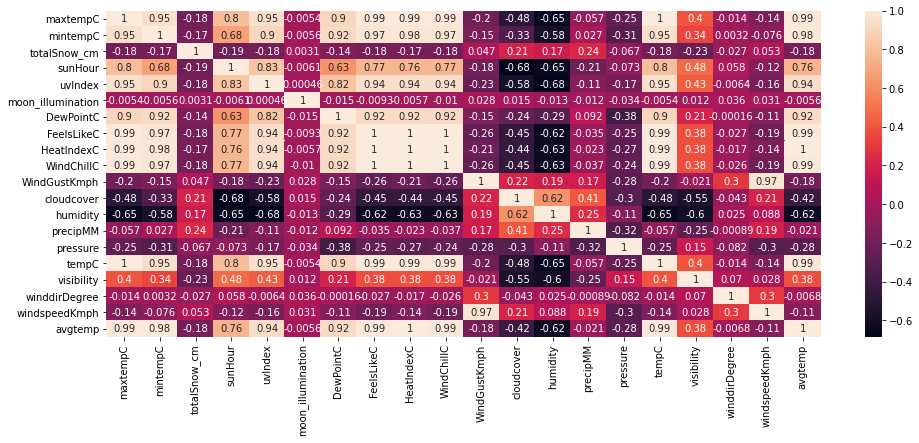

In [10]:
# Correlations among columns
import seaborn as sns

correlation_mat = df.corr()
plt.figure(figsize = (16,6))
sns.heatmap(correlation_mat, annot = True)
plt.show()


In [11]:
# some correlations were too high for me, so i dropped those columns 
# e.g the correlations between  feelslikec, heatindexc and windchillc is way too high to keep all of those in the dataset
df.drop(df[['moonrise','moonset','sunrise','sunset','location', 'FeelsLikeC', 'HeatIndexC', 'WindChillC', 'tempC']], axis=1, inplace=True)
df.head()

,maxtempC,mintempC,totalSnow_cm,sunHour,uvIndex,moon_illumination,DewPointC,WindGustKmph,cloudcover,humidity,precipMM,pressure,visibility,winddirDegree,windspeedKmph,avgtemp
date_time,,,,,,,,,,,,,,,,
2010-01-01,6,3,0.0,6.9,1,100,4,16,64,94,0.8,992,5,175,9,4.5
2010-01-02,3,-1,0.0,3.3,1,85,0,31,75,89,1.7,1003,5,286,21,1.0
2010-01-03,-1,-4,0.0,3.3,1,77,-5,39,82,79,1.7,1016,8,319,26,-2.5
2010-01-04,-3,-7,0.0,8.7,2,70,-7,16,38,80,0.0,1021,10,195,10,-5.0
2010-01-05,-3,-5,1.0,3.3,1,63,-5,25,91,92,1.1,1013,7,90,17,-4.0


In [14]:
# a function to create a dataset where we have the data from the previous days
#data: dataset, days_before: previous days, days_after= how many days ahead we want to predict, special: are we predicting more than 1 day ahead or not 

def series_to_supervised(data, days_before=14, days_after=1, dropnan=True, special = False):
	n_vars = 1 if type(data) is list else data.shape[1]
	dff = pd.DataFrame(data)
	cols, names = list(), list()

	for i in range(days_before, 0, -1):
		cols.append(dff.shift(i))
		names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]

	for i in range(0, days_after):
		cols.append(dff.shift(-i))
		if i == 0:
			names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
		else:
			names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]

	agg = pd.concat(cols, axis=1)
	agg.columns = names

	if special:
		for j in range(1,days_after,1):
			for i in range(len(data.columns)):
				if i+1 != len(data.columns) :	
					agg.drop(agg[['var%d(t+%d)' % (i+1, j)]], inplace=True, axis=1)  #delete later days (e.g. 0..6) and all values 
				else:
					if j != days_after-1:
						agg.drop(agg[['var%d(t+%d)' % (i+1, j)]], inplace=True, axis=1) #delete later days (e.g. 0..6) and all values 

		for i in range(len(data.columns)):
			agg.drop(agg[['var%d(t)' % (i+1)]], inplace=True, axis=1)   #delete all columns thats not the y value
	else:
		for i in range(len(data.columns)):
			if i != len(data.columns)-1:	agg.drop(agg[['var%d(t)' % (i+1)]], inplace=True, axis=1)

	agg.dropna(inplace=True)
	return agg
 

In [32]:
look_back = 5  #how many days we want to use for use prediction from the past 
recalc_for_day = series_to_supervised(df,look_back,1,special=False) 
recalc_for_week = series_to_supervised(df,look_back,7,special=True) 
recalc_for_month = series_to_supervised(df,look_back,28,special=True) 


In [34]:
def test_train_creator(recalc):
# split into train and test sets
  values = recalc.values

  n_train_time = 2500                              
  train = values[:n_train_time, :]
 
  test = values[n_train_time:, :]
 
  
  train_X, train_y = train[:, :-1], train[:, -1]
  test_X, test_y = test[:, :-1], test[:, -1]
  
  
  #LSTM wants our data in a special way
  train_X = train_X.reshape((train_X.shape[0], 1, 16*look_back))   #16 because we have 16 columns after dropping some from before 
  test_X = test_X.reshape((test_X.shape[0], 1, 16*look_back))
  
 
  return train_X, train_y, test_X, test_y

#generate the train and test sets for given predictions
train_x_day, train_y_day , test_x_day, test_y_day = test_train_creator(recalc_for_day)
train_x_week, train_y_week , test_x_week, test_y_week = test_train_creator(recalc_for_week)
train_x_month, train_y_month , test_x_month, test_y_month = test_train_creator(recalc_for_month)

## **Model Building + Training**

## **MLP**

In [30]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.initializers import HeNormal


mlp_model = Sequential()
mlp_model.add(Dense(200, activation='relu', kernel_initializer=HeNormal(), input_shape=(1,look_back*16)))
mlp_model.add(Dense(70, activation='relu', kernel_initializer=HeNormal()))
mlp_model.add(Dropout(0.1))
mlp_model.add(Dense(30, activation='relu', kernel_initializer=HeNormal()))
mlp_model.add(Dense(1))

mlp_model.compile(loss='mse', optimizer='adam', metrics=['accuracy'])
mlp_history = mlp_model.fit(train_x_day, train_y_day, epochs=500, batch_size=128, validation_data=(test_x_day, test_y_day), verbose=1, shuffle=False)

Epoch 1/500
20/20 [==============================] - 0s 13ms/step - loss: 10476.7793 - accuracy: 0.0088 - val_loss: 582.0949 - val_accuracy: 0.0133
Epoch 2/500
20/20 [==============================] - 0s 6ms/step - loss: 1687.7068 - accuracy: 0.0168 - val_loss: 127.1115 - val_accuracy: 0.0158
Epoch 3/500
20/20 [==============================] - 0s 5ms/step - loss: 1011.1038 - accuracy: 0.0156 - val_loss: 146.8477 - val_accuracy: 0.0149
Epoch 4/500
20/20 [==============================] - 0s 5ms/step - loss: 798.0592 - accuracy: 0.0132 - val_loss: 107.8645 - val_accuracy: 0.0149
Epoch 5/500
20/20 [==============================] - 0s 5ms/step - loss: 569.7623 - accuracy: 0.0140 - val_loss: 84.8396 - val_accuracy: 0.0149
Epoch 6/500
20/20 [==============================] - 0s 5ms/step - loss: 436.9417 - accuracy: 0.0172 - val_loss: 87.3224 - val_accuracy: 0.0149
Epoch 7/500
20/20 [==============================] - 0s 6ms/step - loss: 357.9831 - accuracy: 0.0160 - val_loss: 66.1966 - val_

# **CNN**

In [18]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv1D, MaxPooling1D, Dropout, Flatten, Embedding, GlobalMaxPooling1D
from tensorflow.keras.optimizers import SGD, RMSprop

model = Sequential() 
model.add(Conv1D(200, kernel_size=1, activation='relu', input_shape=(1,look_back*16))) 
model.add(Dropout(0.2))
model.add(MaxPooling1D(1))
model.add(Conv1D(32,1, activation='relu'))
model.add(Dropout(0.5))
model.add(GlobalMaxPooling1D())
model.add(Dense(1)) 

print(model.summary())

model.compile(loss='mse', optimizer='adam', metrics=['accuracy'])
network_history = model.fit(train_x_day, train_y_day, epochs=500, batch_size=128, validation_data=(test_x_day, test_y_day), verbose=1, shuffle=False)

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 1, 200)            9800      
_________________________________________________________________
dropout_1 (Dropout)          (None, 1, 200)            0         
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 1, 200)            0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 1, 32)             6432      
_________________________________________________________________
dropout_2 (Dropout)          (None, 1, 32)             0         
_________________________________________________________________
global_max_pooling1d (Global (None, 32)                0         
_________________________________________________________________
dense_4 (Dense)              (None, 1)                

## **LSTM**

In [35]:
import random
import keras
from keras.layers import Dense
from keras.models import Sequential
from keras.utils import to_categorical
from keras.optimizers import SGD, Adam
from keras.callbacks import EarlyStopping
from keras.utils import np_utils
import itertools
from keras.layers import LSTM
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
from keras.layers import Dropout


model = Sequential()
model.add(LSTM(200, activation='relu', return_sequences=True, input_shape=(1, look_back*16)))  #
model.add(Dense(100))
model.add(Dropout(0.2))
model.add(Dense(20))

model.add(Dense(1))

callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=100)

model.compile(loss='mean_squared_error', optimizer=Adam(lr=0.001) , metrics=['accuracy'])


In [36]:
# fit network
history = model.fit(train_x_day, train_y_day, epochs=1000, batch_size=128, validation_data=(test_x_day, test_y_day), verbose=1, callbacks = [callback], shuffle=False)

Epoch 1/1000
20/20 [==============================] - 0s 19ms/step - loss: 681.9556 - accuracy: 0.0132 - val_loss: 112.8156 - val_accuracy: 0.0199
Epoch 2/1000
20/20 [==============================] - 0s 7ms/step - loss: 146.7941 - accuracy: 0.0156 - val_loss: 46.9555 - val_accuracy: 0.0141
Epoch 3/1000
20/20 [==============================] - 0s 8ms/step - loss: 72.0742 - accuracy: 0.0124 - val_loss: 31.3150 - val_accuracy: 0.0150
Epoch 4/1000
20/20 [==============================] - 0s 7ms/step - loss: 44.0978 - accuracy: 0.0156 - val_loss: 23.1428 - val_accuracy: 0.0183
Epoch 5/1000
20/20 [==============================] - 0s 7ms/step - loss: 34.7452 - accuracy: 0.0144 - val_loss: 19.3421 - val_accuracy: 0.0183
Epoch 6/1000
20/20 [==============================] - 0s 7ms/step - loss: 28.3972 - accuracy: 0.0144 - val_loss: 17.3146 - val_accuracy: 0.0183
Epoch 7/1000
20/20 [==============================] - 0s 7ms/step - loss: 23.1323 - accuracy: 0.0152 - val_loss: 14.8683 - val_accur

Right now we can see that LSTM gives the best results, so we will use that for the predictions. 

In [38]:
def predict(model):
  args = (df.values[-1].tolist(),df.values[-2].tolist(),df.values[-3].tolist(), df.values[-4].tolist(),df.values[-5].tolist())

  arr = np.concatenate(args)
  arr = arr.flatten()

  arr = arr.reshape(1,1,16*look_back)

  y = model.predict(arr)
  return y

print("Preidction for the next day: %f" %predict(model))

Preidction for the next day: 12.302802


In [39]:
model.compile(loss='mean_squared_error', optimizer=Adam(lr=0.001) , metrics=['accuracy'])
history = model.fit(train_x_week, train_y_week, epochs=1000, batch_size=128, validation_data=(test_x_week, test_y_week), verbose=0, callbacks = [callback], shuffle=False)


In [40]:
print("Preidction for a week ahead (4th of november): %f" %predict(model))

Preidction for a week ahead (4th of november): 8.758175


In [41]:
model.compile(loss='mean_squared_error', optimizer=Adam(lr=0.001) , metrics=['accuracy'])
history = model.fit(train_x_month, train_y_month, epochs=1000, batch_size=128, validation_data=(test_x_month, test_y_month), verbose=0, callbacks = [callback], shuffle=False)


In [43]:

print("Preidction for a month ahead (24th of november): %f" %predict(model))

Preidction for a month ahead (24th of november): 3.232396
